# Teil 3: Daten Vorbereiten und Modellieren
## Mit einem linearen Klassifizierungs-Modell zur Kategoriebestimmung

Nachdem wir die Daten bereinigt und visualisiert haben, können wir mit dem Modellieren beginnen. Wir werden ein lineares Klassifizierungs-Modell aus der Bibliothek `sklearn` verwenden, um die Kategorie zu bestimmen. Wir werden dann die Daten in Trainings- und Testdaten aufteilen und das Modell auf den Trainingsdaten trainieren. Anschließend werden wir die Testdaten verwenden, um die Genauigkeit des Modells zu testen.

Als sog. Features fuer unser Modell nehmen wir nur ein Teilmenge der vorhandenen Spalten. Zum einen, da nicht alle Spalten einen hohen Einfluss auf die Kategorie haben, zum anderen, um die Anzahl der Features zu reduzieren, um die Berechnung zu beschleunigen und das Modell "robuster" zu machen.

Zuvor haben wir in unseren Pair-Plots bereits gesehen, dass nicht alle Variablen helfen, die Kategorien zu unterscheiden. Wir werden daher nur folgende Variablen als Features verwenden:
`Head Tube Angle`, `Reach`, `Stack`, `STR`, `Wheelbase`.

Weitere Spalten wie `Brand`, `Model` und `Frame Size` sind explizit ekludiert, damit das Modell nicht einfach nur eine Assoziation zwischen Modell und Gemotrie auswendig lernt und in Folge nicht auf ungesehene Daten generalisieren kann.

Ferner wird die Kategorie `Other` exkludiert, da diese unzureichend wenige Beispiele hat um das Modell zu trainieren.

In [12]:
import polars as pl
import sklearn.svm as svm
import sklearn.metrics as metrics
import sklearn.model_selection as model_selection
from sklearn.preprocessing import StandardScaler

In [13]:
df = pl.read_ipc('resources/data/bicycle-geometry/geometrics.mtb-news.de.arrow', memory_map=False)
# print column names and datatypes together
print(*zip(df.columns, df.dtypes))
# cast years to integers
df = df.with_columns(pl.col('Year').cast(pl.Int32))

# These values are not commonly stated so we drop them
# Motorized is all False so we drop it
df = df.drop(['Motorized', 'Top Tube Length Horizontal', 'Fork Trail'])

('URL', Utf8) ('Brand', Utf8) ('Model', Utf8) ('Year', Utf8) ('Category', Utf8) ('Motorized', Boolean) ('Frame Size', Utf8) ('Frame Config', Utf8) ('Wheel Size', Utf8) ('Reach', Float32) ('Stack', Float32) ('STR', Float32) ('Front Center', Float32) ('Head Tube Angle', Float32) ('Seat Tube Angle Effective', Float32) ('Seat Tube Angle Real', Float32) ('Top Tube Length', Float32) ('Top Tube Length Horizontal', Float32) ('Head Tube Length', Float32) ('Seat Tube Length', Float32) ('Standover Height', Float32) ('Chainstay Length', Float32) ('Wheelbase', Float32) ('Bottom Bracket Offset', Float32) ('Bottom Bracket Height', Float32) ('Fork Installation Height', Float32) ('Fork Offset', Float32) ('Fork Trail', Float32) ('Suspension Travel (rear)', Float32) ('Suspension Travel (front)', Float32)


In [14]:
# this is the list of features that we want to use to predict the category
features = [
    'Head Tube Angle',
    #'Chainstay Length',
    'Reach',
    'Stack',
    'STR',
    #'Seat Tube Angle Effective', # this costs us about a fifth of our current data points!
    'Wheelbase',
    #'Bottom Bracket Offset',
]
# this is the target column that we want to predict
target = 'Category'

# because our plotting dataframe was filtered for null values of columns we dont use for modeling
# we need to filter the original dataframe with the conditions only for the used columns 
df = df.select(
    features + [target]
).filter(
    ~pl.all(pl.col('Category') == 'Other') &
    (pl.col('Wheelbase') < 3000) &
    (pl.col('Wheelbase') > 500) &
    (pl.col('STR') > 1.0) & 
    (pl.col('Reach') > 300) &
    (pl.col('Stack') > 470) &
    (pl.col('Head Tube Angle') > 61.0) 
    #(pl.col('Seat Tube Angle Effective') > 70)
).drop_nulls()

# print the shape of data we are left with:
print(f'Numer of samples: {df.select(features + [target]).shape[0]}')

Numer of samples: 5095


Wir werden eines der einfachsten Machine-Learning Modelle verwenden, eine lineare Support-Vector-Machine.

> Hint: Tafelbeispiel!

Die Modell hat viele gute Default-Werte, wir ueberschreiben hier nur einige davon:

In [15]:
model = svm.LinearSVC(
    C=10,               # error penalty: vary this parameter to change how "tightly" the model fits the data e.g 0.1, 1, 10, 100
    max_iter=100000,     # safeguard against too long training times in case of no convergence
    random_state=42,    # set a random seed to make the results reproducible
)

Bis jetzt ist das Modell nur instanziiert aber noch nicht trainiert. Das machen wir im nächsten Schritt.

Um das Modell zu trainieren, muessen wir die Daten in ein sog. Trainings- und Testset aufteilen (zumindest, mehr dazu spaeter).
Das Trainingsset ist eine zufaellige Auswahl von Samples, die verwendet werden, um das Modell an die Daten anzupassen. Das Testset wird verwendet, um die Vorhersageleistung des Modells auf unbekannte Daten zu bewerten.
Das Testen ist wichtig, um zu ueberpruefen, ob das Modell gut auf neue Daten generalisiert, und nicht nur die Trainingsdaten memorisiert. Das Testset ist in der Regel kleiner als das Trainingsset, da wir so viele Daten wie moeglich fuer das Training verwenden moechten. Das Testset muss aber ebenso vielfaeltig genug sein, um die Vorhersageleistung des Modells zu bemessen.

> **Merke:** Technisch gesehen wuerden wir noch ein drittes sog. "Validierungs"-Set benoetigen mit dem eine Menge von verschiedenen Modellparametern ausprobiert wird, um die beste Leistung zu finden. Das waere aber zu viel fuer diese einfache Demo (wir bleiben bei fixem C).

Da scikit keine Arrow-Unterstuetzung hat, werden wir unseren finalen Dataframe in `numpy` Arrays konvertieren.

`sklearn` hat bereits eine bequeme Funktion, um die Daten in Trainings- und Testset aufzuteilen.

In [16]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    df.select(features).to_numpy(),
    df.get_column(target).to_numpy(), 
    test_size=0.33, 
    random_state=42
)

Besonders wichtig ist, die Daten auf den selben Wertebereich zu skalieren, damit die Features mathematisch gleich gewichtet werden. Wir benutzen hierfuer den `StandardScaler`, der die Daten auf eine Mittelwert von 0 und eine Standardabweichung von 1 skaliert.

              precision    recall  f1-score   support

   Gravel/CX       0.94      0.74      0.83       205
    Mountain       0.99      1.00      0.99      1326
        Road       0.81      0.95      0.88       151

    accuracy                           0.96      1682
   macro avg       0.91      0.90      0.90      1682
weighted avg       0.96      0.96      0.96      1682

[[0.74146341 0.09756098 0.16097561]
 [0.0015083  0.9984917  0.        ]
 [0.04635762 0.         0.95364238]]


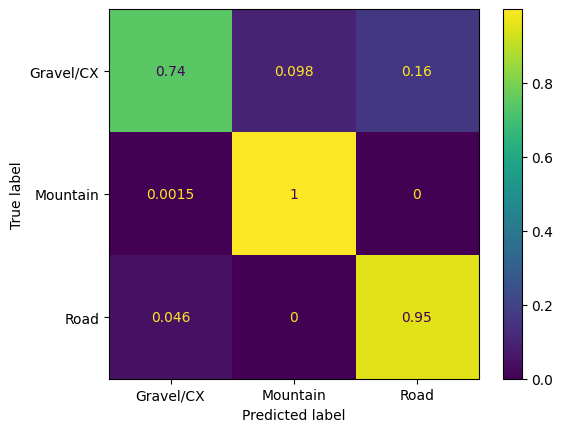

In [17]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
# CRUCIAL: test data needs to be transformed with the scalings from training data
X_test = scaler.transform(X_test)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(metrics.classification_report(y_test, y_pred))

print(metrics.confusion_matrix(y_test, y_pred, normalize='true'))

metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(y_test, y_pred, normalize='true'), display_labels=model.classes_).plot()

## Abschlussbemerkungen

- Wir haetten mehr Samples inkludieren koennen, wenn wir nicht so agressiv gefiltert haetten. Wir haben jedoch unser Domaenenwissen genutzt, um Ausreisser und unrepresentative Samples zu entfernen. Dieses Domaenenwissen ist in der Praxis sehr wichtig, um die Daten zu verstehen und zu bereinigen.
- Merke, dass `StandardScaler` nicht der einzige Weg ist, Daten zu skalieren. Es gibt andere Methoden, die fuer Ihre Daten geeigneter sein koennten. Es funktioniert jedoch in vielen Faellen sehr gut.
- Wir haben Outliers manuell entfernt, aber es gibt auch automatische Methoden, um eine Menge von potentiellen Outliers zu produzieren, welche die manuelle Arbeit erheblich reduzieren (z.B. `sklearn.ensemble.IsolationForest`)
- Modellvalidierung ist ein komplexes Thema, das weit ueber den Rahmen dieses Tutorials hinausgeht. Zuersteinmal ist die Wahl der richtigen Performance-Metrik essentiell.  Darueber hinaus muss die Validierung immer ueber eine Menge von verschiedenen Skalierungs-Methoden und Parametern durchgefuehrt werden, um die beste Permutation zu finden.
- Wir haben die Feature-Selection manuell durchgefuehrt, aber sie kann auch Teil des Validierungsprozesses sein (weiteres Lesen: Filter vs. Wrapper Ansatz).